In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model_evaluation import evaluate_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [2]:
# notebook parameters
input_dataset_path = 'data/heart.csv'

#### Functions

In [3]:
heart_df = pd.read_csv(input_dataset_path)
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=['target']).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df['target'].unique()}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 1025 rows and 14 colums
Input dataset consists of 13 features and 1 target column
Target values are: [0 1]
Input dataset contains 723 duplicated rows and 302 unique rows


In [5]:
# divide a heart failure dataset into features and target value sets
x = heart_df.drop(columns=['target'])
y = heart_df['target']

In [6]:
# Select training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    random_state=12, 
                                                    test_size=0.25)

print(f"Training dataset consists of {x_train.shape[0]} records")
print(f"Test dataset consists of {x_test.shape[0]} records")

Training dataset consists of 768 records
Test dataset consists of 257 records


In [7]:
# some models are sensitive for feature value scale differences
# StandardScaler is used to transform those values into rescaled format, without information loss
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

In [8]:
# Transform target data sets into binary matrix representation of the target values
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

### Decision Tree

Model accuracy: 100.0%
Model precision: 100.0%
Model recall: 100.0%
Model F1-score: 1.0
Model Matthews Correlation Coefficient (MCC): 1.0
Model overall classification report:
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       138

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257



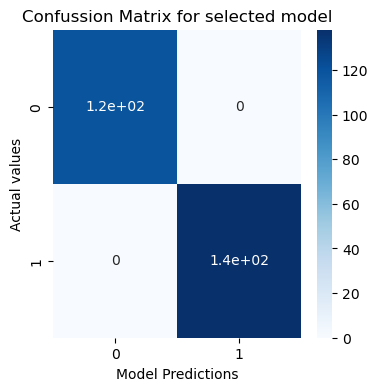

In [9]:
dt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')

dt_model.fit(x_train, y_train)
dt_score = evaluate_model(dt_model, x_test=x_test, y_test=y_test)

[Text(0.4699292452830189, 0.95, 'x[2] <= -0.411\nentropy = 1.0\nsamples = 768\nvalue = [380, 388]'),
 Text(0.2641509433962264, 0.85, 'x[11] <= -0.269\nentropy = 0.788\nsamples = 382\nvalue = [292, 90]'),
 Text(0.16981132075471697, 0.75, 'x[12] <= 0.274\nentropy = 0.998\nsamples = 164\nvalue = [86, 78]'),
 Text(0.09433962264150944, 0.65, 'x[8] <= 0.32\nentropy = 0.824\nsamples = 93\nvalue = [24, 69]'),
 Text(0.03773584905660377, 0.55, 'x[0] <= 0.604\nentropy = 0.509\nsamples = 62\nvalue = [7, 55]'),
 Text(0.018867924528301886, 0.45, 'entropy = 0.0\nsamples = 41\nvalue = [0, 41]'),
 Text(0.05660377358490566, 0.45, 'x[0] <= 0.766\nentropy = 0.918\nsamples = 21\nvalue = [7, 14]'),
 Text(0.03773584905660377, 0.35, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.07547169811320754, 0.35, 'x[7] <= -2.211\nentropy = 0.672\nsamples = 17\nvalue = [3, 14]'),
 Text(0.05660377358490566, 0.25, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.09433962264150944, 0.25, 'entropy = 0.0\nsampl

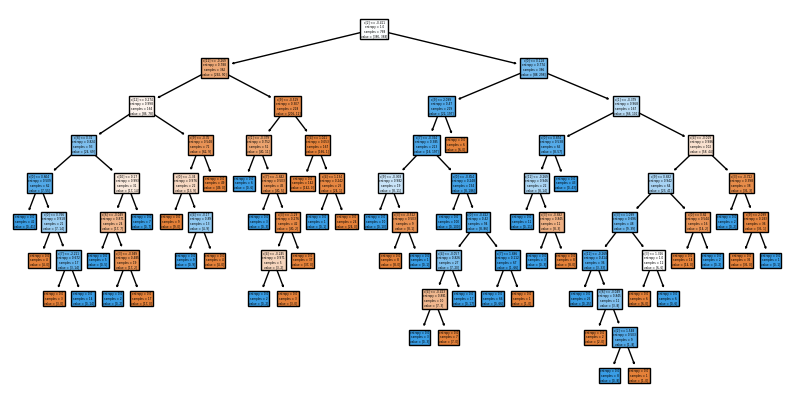

In [10]:
# this model is overfitted
plt.figure(figsize=(10,5))
tree.plot_tree(dt_model,filled=True)

### Pruning Decision Tree

In [11]:
base_pdt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')
ccp_path = base_pdt_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [12]:
pdt_models = []
for ccp_alpha in ccp_alphas:
    pdt_model = DecisionTreeClassifier(random_state=11,
                                       ccp_alpha=ccp_alpha)
    pdt_model.fit(x_train, y_train)

    # add Pruning Decision Tree classifier to list of trees
    pdt_models.append(pdt_model)

In [13]:
print(f"Last tree in list has {pdt_models[-1].tree_.node_count} for cpp_alpha parameter {ccp_alphas[-1]}")

Last tree in list has 1 for cpp_alpha parameter 0.21889506422498584


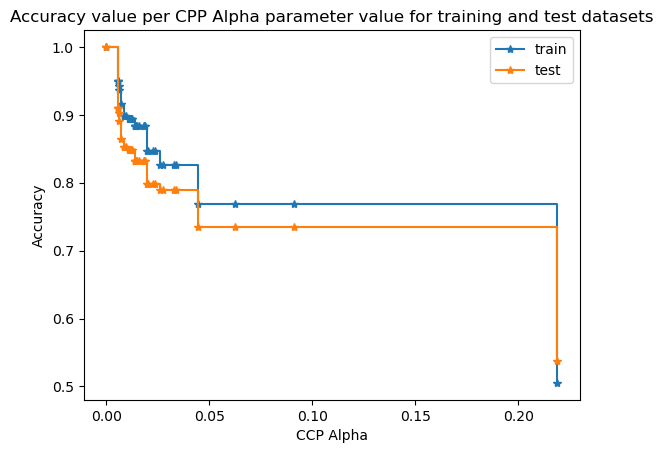

In [14]:
train_scores = [tree.score(x_train, y_train) for tree in pdt_models]
test_scores = [tree.score(x_test, y_test) for tree in pdt_models]

fig, ax = plt.subplots()
ax.set_xlabel("CCP Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy value per CPP Alpha parameter value for training and test datasets")
ax.plot(ccp_alphas, 
        train_scores, 
        marker='*', 
        label='train', 
        drawstyle="steps-post")
ax.plot(ccp_alphas, 
        test_scores, 
        marker='*', 
        label='test', 
        drawstyle="steps-post")
ax.legend()
plt.show()

Model accuracy: 73.54085603112841%
Model precision: 74.64788732394366%
Model recall: 76.81159420289855%
Model F1-score: 0.7571428571428571
Model Matthews Correlation Coefficient (MCC): 0.4669046266027146
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       119
           1       0.75      0.77      0.76       138

    accuracy                           0.74       257
   macro avg       0.73      0.73      0.73       257
weighted avg       0.74      0.74      0.74       257



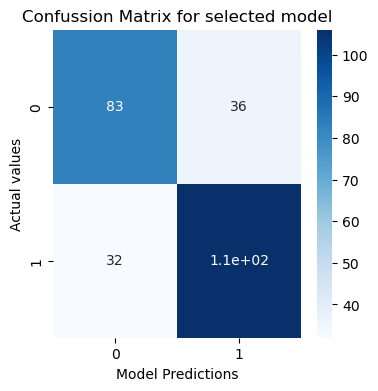

In [15]:
pdt_model = DecisionTreeClassifier(random_state=11,
                             ccp_alpha=0.09, 
                             criterion='entropy')
pdt_model.fit(x_train,y_train)
pdt_score = evaluate_model(pdt_model, x_test=x_test, y_test=y_test)

[Text(0.6, 0.8333333333333334, 'x[2] <= -0.411\nentropy = 1.0\nsamples = 768\nvalue = [380, 388]'),
 Text(0.4, 0.5, 'x[11] <= -0.269\nentropy = 0.788\nsamples = 382\nvalue = [292, 90]'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.998\nsamples = 164\nvalue = [86, 78]'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.307\nsamples = 218\nvalue = [206, 12]'),
 Text(0.8, 0.5, 'entropy = 0.774\nsamples = 386\nvalue = [88, 298]')]

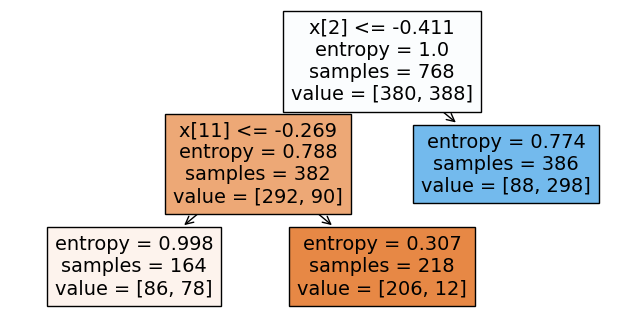

In [16]:
plt.figure(figsize=(8,4))
tree.plot_tree(pdt_model, filled=True)

### Random Forest

Model accuracy: 87.15953307392996%
Model precision: 86.7132867132867%
Model recall: 89.85507246376811%
Model F1-score: 0.8825622775800711
Model Matthews Correlation Coefficient (MCC): 0.7416013680835589
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       119
           1       0.87      0.90      0.88       138

    accuracy                           0.87       257
   macro avg       0.87      0.87      0.87       257
weighted avg       0.87      0.87      0.87       257



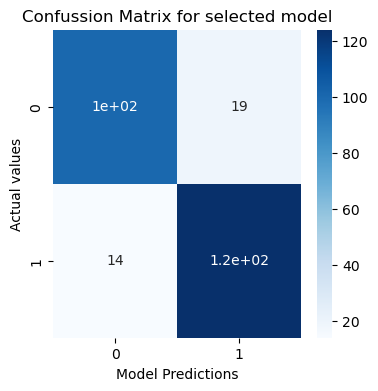

In [17]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_samples_leaf=10,
                                  random_state=11,
                                  n_jobs=1)

rf_model.fit(x_train, y_train)
rf_score = evaluate_model(rf_model, x_test=x_test, y_test=y_test)

### CNN model

In [18]:
cnn_model = Sequential()
cnn_model.add(Dense(256, 
                    input_dim=13, 
                    activation='relu'))
cnn_model.add(Dense(256, 
                    activation='relu'))
cnn_model.add(Dense(2, 
                    activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(f"CNN model summary: \n{cnn_model.summary()}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 69890 (273.01 KB)
Trainable params: 69890 (273.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CNN model summary: 
None


In [19]:
cnn_model.fit(x_train, 
              y_cat_train, 
              epochs=10, 
              validation_data=(x_test, y_cat_test))

Epoch 1/10
24/24 [==============================] - 1s 13ms/step - loss: 0.4062 - accuracy: 0.8438 - val_loss: 0.3829 - val_accuracy: 0.8093
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.3038 - accuracy: 0.8841 - val_loss: 0.3432 - val_accuracy: 0.8755
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2545 - accuracy: 0.9076 - val_loss: 0.2968 - val_accuracy: 0.8988
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9193 - val_loss: 0.2568 - val_accuracy: 0.9183
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1832 - accuracy: 0.9349 - val_loss: 0.2210 - val_accuracy: 0.9261
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1604 - accuracy: 0.9427 - val_loss: 0.1860 - val_accuracy: 0.9416
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1301 - accuracy: 0.9609 - val_loss: 0.1701 - val_accuracy: 0.9183
Epoch 8/10
24/24 [=

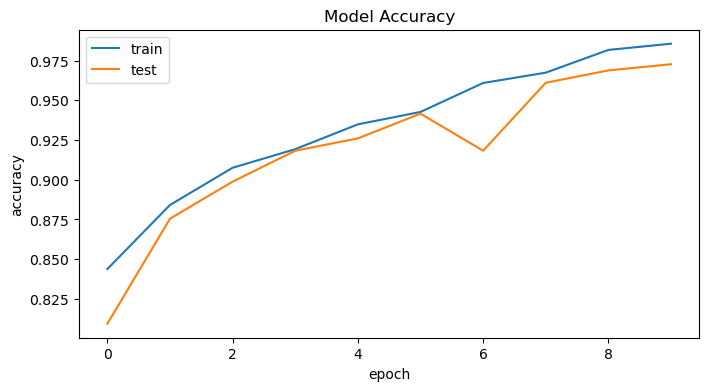

In [20]:
plt.figure(figsize=(8,4))
plt.plot(cnn_model.history.history['accuracy'])
plt.plot(cnn_model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

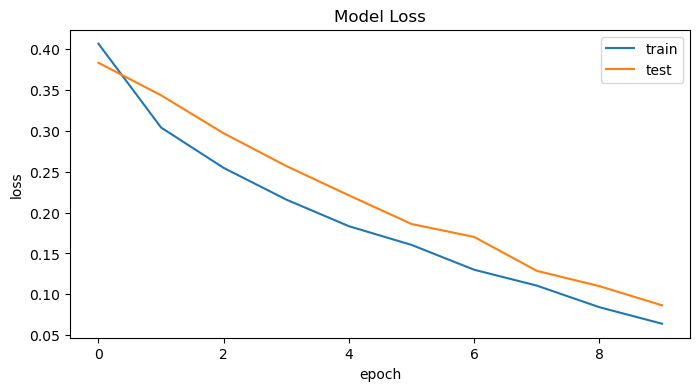

In [21]:
# Model Losss
plt.figure(figsize=(8,4))
plt.plot(cnn_model.history.history['loss'])
plt.plot(cnn_model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [22]:
print(f"CNN model evaluation after training: {cnn_model.evaluate(x_train, y_cat_train)}")
print (f"CNN model evaluation for test dataset: {cnn_model.evaluate(x_test, y_cat_test)}")

24/24 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.9948
CNN model evaluation after training: [0.05109467729926109, 0.9947916865348816]
9/9 [==============================] - 0s 2ms/step - loss: 0.0866 - accuracy: 0.9728
CNN model evaluation for test dataset: [0.08659359812736511, 0.9727626442909241]


9/9 [==============================] - 0s 1ms/step
Model accuracy: 97.27626459143968%
Model precision: 96.45390070921985%
Model recall: 98.55072463768117%
Model F1-score: 0.974910394265233
Model Matthews Correlation Coefficient (MCC): 0.9453921172292524
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       119
           1       0.96      0.99      0.97       138

    accuracy                           0.97       257
   macro avg       0.97      0.97      0.97       257
weighted avg       0.97      0.97      0.97       257



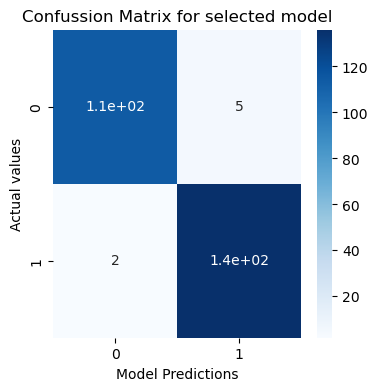

In [23]:
cnn_score = evaluate_model(cnn_model, x_test=x_test, y_test=y_test, is_cnn=True)

### Logistic Regression

Model accuracy: 82.10116731517509%
Model precision: 81.94444444444444%
Model recall: 85.5072463768116%
Model F1-score: 0.8368794326241135
Model Matthews Correlation Coefficient (MCC): 0.6395124505195644
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       119
           1       0.82      0.86      0.84       138

    accuracy                           0.82       257
   macro avg       0.82      0.82      0.82       257
weighted avg       0.82      0.82      0.82       257



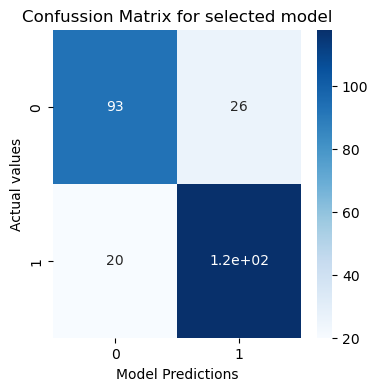

In [24]:
lr_model = LogisticRegression(random_state=0, C=10, penalty='l2')
lr_model.fit(x_train, y_train)
lr_score = evaluate_model(lr_model, x_test=x_test, y_test=y_test)

### Support Vector Machine

Model accuracy: 80.54474708171206%
Model precision: 78.94736842105263%
Model recall: 86.95652173913044%
Model F1-score: 0.8275862068965517
Model Matthews Correlation Coefficient (MCC): 0.609289362894214
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       119
           1       0.79      0.87      0.83       138

    accuracy                           0.81       257
   macro avg       0.81      0.80      0.80       257
weighted avg       0.81      0.81      0.80       257



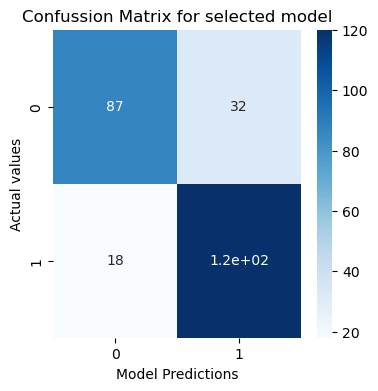

In [25]:
svm_model = SVC(kernel='linear', C=0.3)
svm_model.fit(x_train, y_train)
svm_score = evaluate_model(svm_model, x_test=x_test, y_test=y_test)

### K Nearest Neighbours

Model accuracy: 92.99610894941634%
Model precision: 91.66666666666666%
Model recall: 95.65217391304348%
Model F1-score: 0.9361702127659574
Model Matthews Correlation Coefficient (MCC): 0.8596163147791199
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       119
           1       0.92      0.96      0.94       138

    accuracy                           0.93       257
   macro avg       0.93      0.93      0.93       257
weighted avg       0.93      0.93      0.93       257



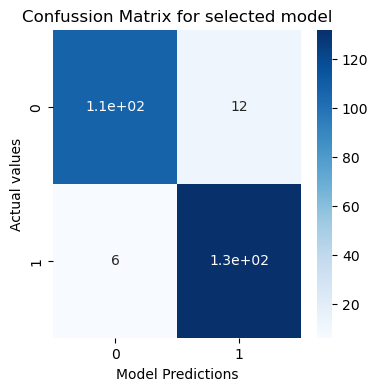

In [26]:
knn_model = KNeighborsClassifier(leaf_size=1, n_neighbors=3)
knn_model.fit(x_train, y_train)
knn_score = evaluate_model(knn_model, x_test=x_test, y_test=y_test)

### Comparison of models' results

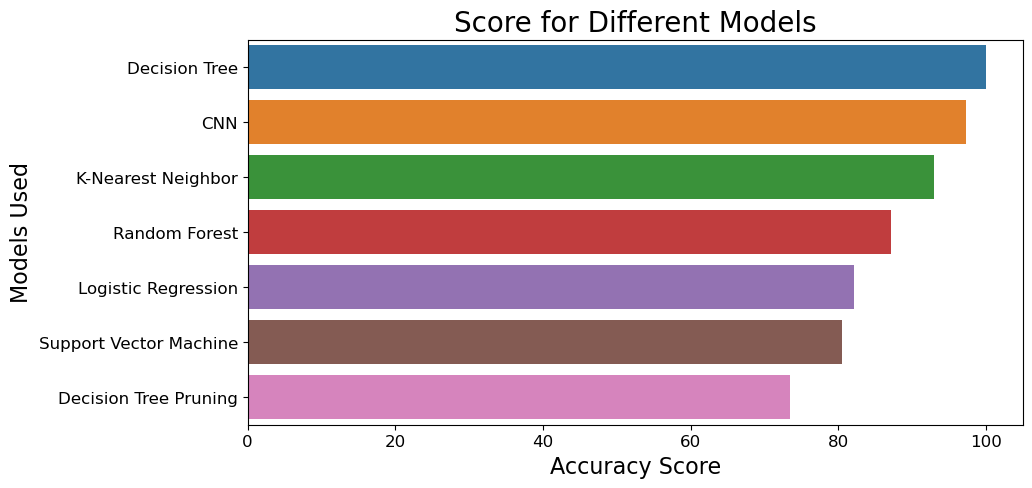

In [27]:
acc_scores = {
    'Decision Tree': dt_score * 100, 
    'Decision Tree Pruning': pdt_score * 100, 
    'Random Forest': rf_score * 100, 
    'Logistic Regression': lr_score * 100,
    'Support Vector Machine': svm_score * 100, 
    'K-Nearest Neighbor': knn_score * 100,
    'CNN': cnn_score * 100
}

acc_scores = dict(sorted(acc_scores.items(), key = lambda x: x[1], reverse = True))
models = list(acc_scores.keys())
score = list(acc_scores.values())

fig = plt.figure(figsize=(10, 5))
sns.barplot(x=score, y=models)
plt.xlabel("Accuracy Score", size = 16)
plt.xticks(size = 12)
plt.ylabel("Models Used", size = 16)
plt.yticks(size = 12)
plt.title("Score for Different Models", size = 20)
plt.show()